# Handling noise in batch7
I was bothered by batch 7.
I'm sure everyone does, too.

As we all know, there is a strong spike in batch 7 that prevents the model from learning.  
(https://www.kaggle.com/c/liverpool-ion-switching/discussion/149846)

When I analyzed batch 7 in detail, I found it to be due to an artificial error.

So, I took the method of replacing the outliers with appropriate values.



# Const

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
PATH_TRAIN = './drive/My Drive/Colab Notebooks/liverpool-ion-switching/data/train_clean_kalman.csv'

# Import everything I need :)

In [0]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# My function

In [0]:
def group_feat_train(_train):
    train = _train.copy()
    # group init
    train['group'] = int(0)

    # group 1
    idxs = (train['batch'] == 3) | (train['batch'] == 7)
    train['group'][idxs] = int(1)

    # group 2
    idxs = (train['batch'] == 5) | (train['batch'] == 8)
    train['group'][idxs] = int(2)

    # group 3
    idxs = (train['batch'] == 2) | (train['batch'] == 6)
    train['group'][idxs] = int(3)

    # group 4
    idxs = (train['batch'] == 4) | (train['batch'] == 9)
    train['group'][idxs] = int(4)
    
    return train[['group']]

# Preparation

setting

In [0]:
sns.set()

<br>

load dataset

In [0]:
df_tr = pd.read_csv(PATH_TRAIN)

<br>

add batch and group

In [0]:
batch_list = []
for n in range(10):
    batchs = np.ones(500000)*n
    batch_list.append(batchs.astype(int))
batch_list = np.hstack(batch_list)
df_tr['batch'] = batch_list

In [0]:
group = group_feat_train(df_tr)
df_tr = pd.concat([df_tr, group], axis=1)

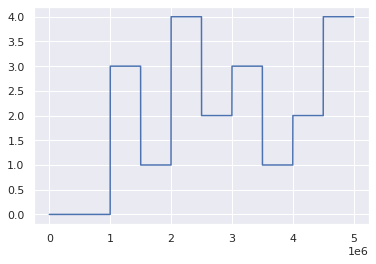

In [43]:
plt.plot(df_tr['group'])

# EDA
Let's plot the batch 7 signals by open_channels.

In [14]:
df_tr['mean_sig'] = df_tr.groupby(['open_channels','batch'])['signal'].transform('mean')
df_tr

,time,signal,open_channels,batch,group,mean_sig
0,0.0001,-2.760655,0,0,0,-2.720454
1,0.0002,-2.848034,0,0,0,-2.720454
2,0.0003,-2.424341,0,0,0,-2.720454
3,0.0004,-3.130037,0,0,0,-2.720454
4,0.0005,-3.144854,0,0,0,-2.720454
...,...,...,...,...,...,...
4999995,499.9996,2.937281,7,9,4,3.175041
4999996,499.9997,2.727728,7,9,4,3.175041
4999997,499.9998,4.506354,8,9,4,4.398596
4999998,499.9999,5.619422,9,9,4,5.621944


Text(0, 0.5, 'signal')

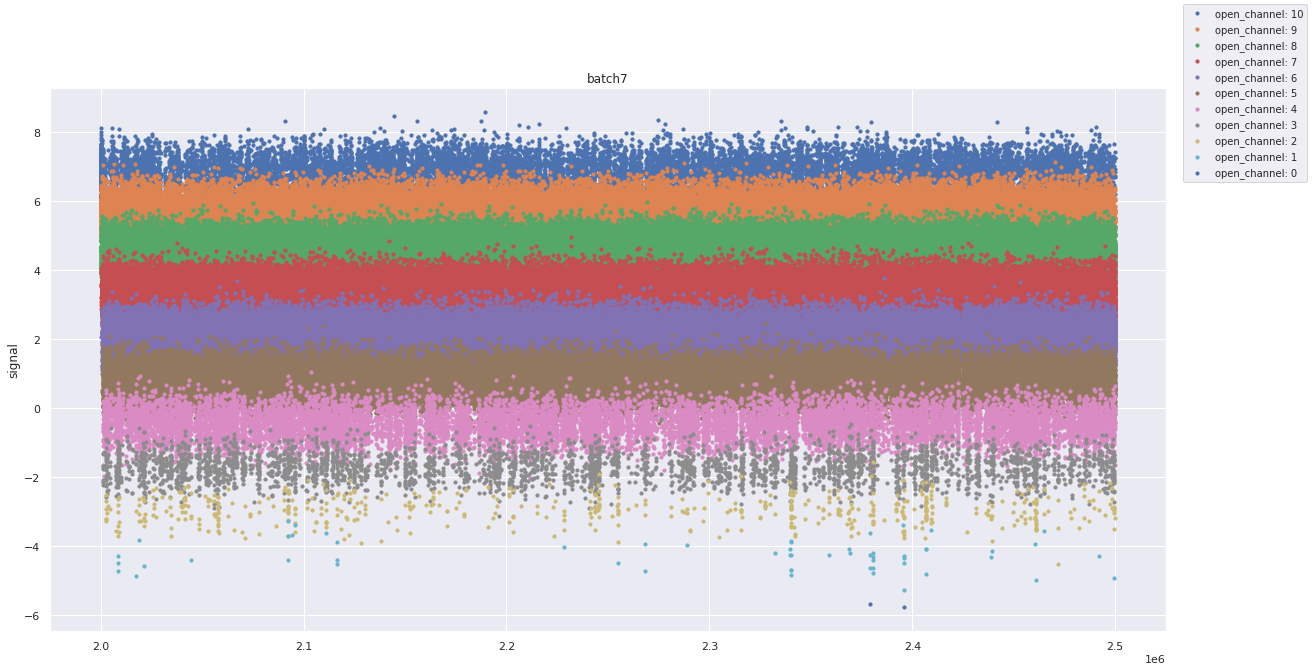

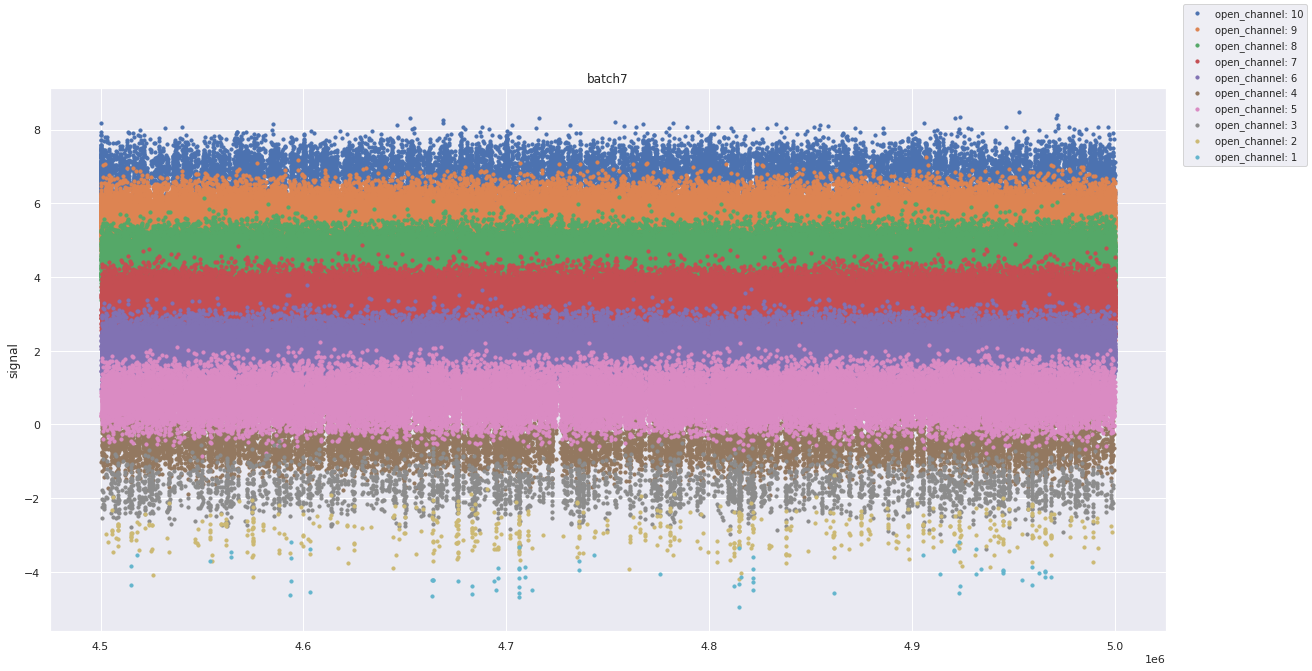

In [27]:
res = 100
x = np.arange(len(df_tr))

fig = plt.figure(figsize=(20, 10))
for i in df_tr[df_tr['batch']==4]['open_channels'].unique():
    idxs = (df_tr['batch'] == 4) & (df_tr['open_channels'].values==i)
    plt.scatter(x[idxs], df_tr['signal'].values[idxs], s=10, label=f'open_channel: {i}')

fig.legend(fontsize=10)
plt.title('batch7')
plt.ylabel('signal')

fig = plt.figure(figsize=(20, 10))
for i in df_tr[df_tr['batch']==9]['open_channels'].unique():
    idxs = (df_tr['batch'] == 9) & (df_tr['open_channels'].values==i)
    plt.scatter(x[idxs], df_tr['signal'].values[idxs], s=10, label=f'open_channel: {i}')
    
fig.legend(fontsize=10)
plt.title('batch7')
plt.ylabel('signal')

---> This result was not what I had imagined.

<br>
Let's look at it in further detail.

Text(0, 0.5, 'signal')

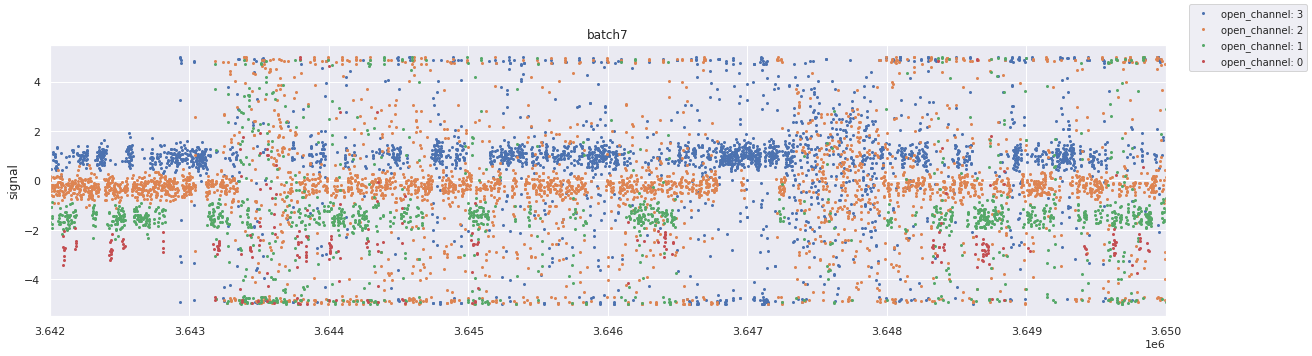

In [46]:
res = 1
x = np.arange(len(df_tr))

fig = plt.figure(figsize=(20, 5))
for i in df_tr[df_tr['batch']==7]['open_channels'].unique():
    idxs = (df_tr['batch'] == 7) & (df_tr['open_channels'].values==i)
    plt.scatter(x[idxs], df_tr['signal'].values[idxs], s=4, label=f'open_channel: {i}')
    
fig.legend(fontsize=10)
plt.xlim(3_642_000, 3_650_000)
plt.title('batch7')
plt.ylabel('signal')

---> There is too much noise.  
---> The signal for open_channels=3 has been present at low values below -2.    
---> I decided to replace the outliers that exist in index=3641000 ~ 3829000 with other appropriate values.  

<br>

For example, replace the value of open_channel=3(blue points).    
The replacement value is the average value of open_channel=3, except for index=3641000~3829000.  

In [0]:
left = 3641000
right = 3829000

Mean value visualization

Text(0, 0.5, 'signal')

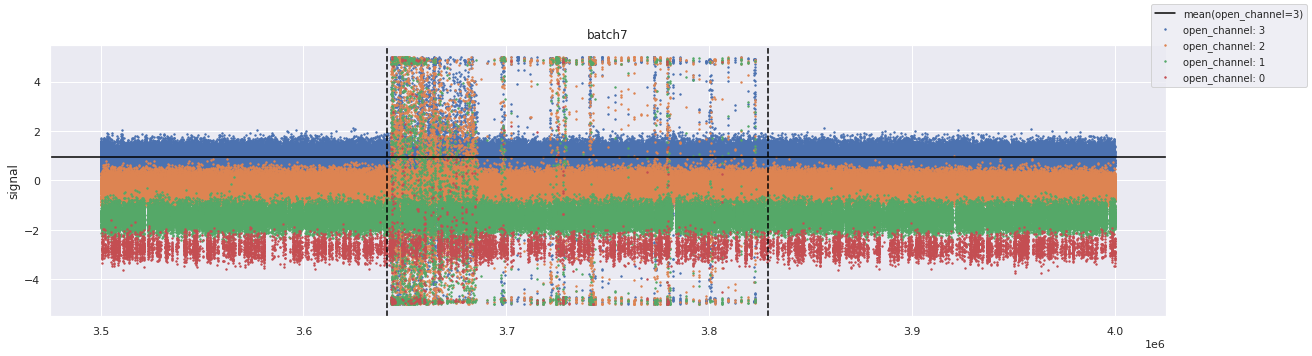

In [48]:
res = 100
x = np.arange(len(df_tr))

fig = plt.figure(figsize=(20, 5))
for i in df_tr[df_tr['batch']==7]['open_channels'].unique():
    idxs = (df_tr['batch'] == 7) & (df_tr['open_channels'].values==i)
    plt.scatter(x[idxs], df_tr['signal'].values[idxs], s=2, label=f'open_channel: {i}')
plt.axvline(left, linestyle='--', color='black')
plt.axvline(right, linestyle='--', color='black')

# batch7 signal mean (without noisy area)
idxs_noisy = (df_tr['open_channels']==3) & (left<df_tr.index) & (df_tr.index<right)
idxs_not_noisy = (df_tr['open_channels']==3) & ~idxs_noisy
plt.axhline(df_tr[idxs_not_noisy]['signal'].mean(), label='mean(open_channel=3)', color='black')
    
fig.legend(fontsize=10)
plt.title('batch7')
plt.ylabel('signal')

<br>
Determine the threshold for outliers.  
In this case, the threshold was determined by eye measurement.

In [0]:
thresh_high = 2.0
thresh_low = 0.1

Text(0, 0.5, 'signal')

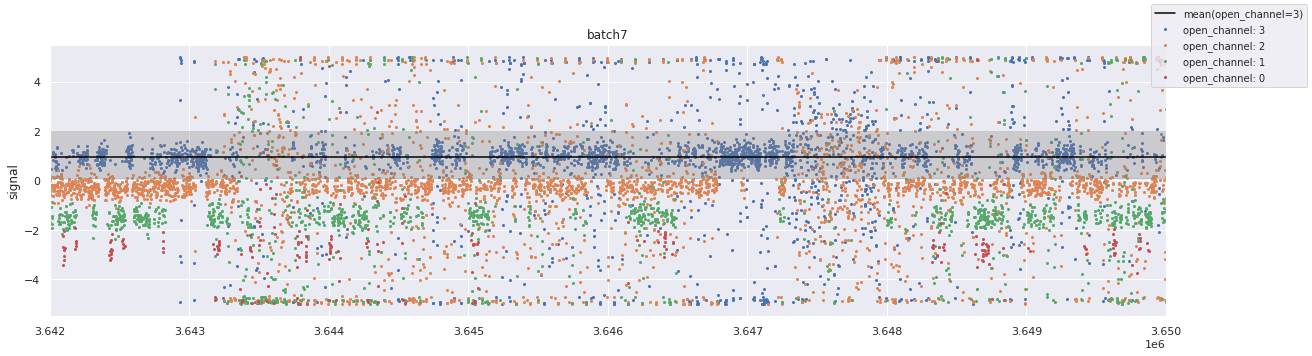

In [50]:
res = 1
x = np.arange(len(df_tr))

fig = plt.figure(figsize=(20, 5))
for i in df_tr[df_tr['batch']==7]['open_channels'].unique():
    idxs = (df_tr['batch'] == 7) & (df_tr['open_channels'].values==i)
    plt.scatter(x[idxs], df_tr['signal'].values[idxs], s=4, label=f'open_channel: {i}')
    
plt.axvline(left, linestyle='--', color='black')

# batch7 signal mean (without noisy area)
idxs_noisy = (df_tr['open_channels']==3) & (left<df_tr.index) & (df_tr.index<right)
idxs_not_noisy = (df_tr['open_channels']==3) & ~idxs_noisy
mean = df_tr[idxs_not_noisy]['signal'].mean()
plt.axhspan(thresh_high, thresh_low, color='gray', alpha=0.3)
plt.axhline(mean, label='mean(open_channel=3)', color='black')
    
fig.legend(fontsize=10)
plt.xlim(3_642_000, 3_650_000)
plt.title('batch7')
plt.ylabel('signal')

---> The signal of open_channels=3, which is out of the gray shading, is taken as an outlier.

<br>
Let's replace the outlier with the average value.

In [0]:
df_tr['signal_mod'] = df_tr['signal'].values

idxs_outlier = idxs_noisy & (thresh_high<df_tr['signal'].values)
data = np.random.normal(loc=mean, scale=0.25, size=idxs_outlier.sum()) #ガウシアンノイズを生成
df_tr['signal_mod'][idxs_outlier]  = data
idxs_outlier = idxs_noisy & (df_tr['signal'].values<thresh_low)
data = np.random.normal(loc=mean, scale=0.25, size=idxs_outlier.sum()) #ガウシアンノイズを生成
df_tr['signal_mod'][idxs_outlier]  = data

Text(0, 0.5, 'signal')

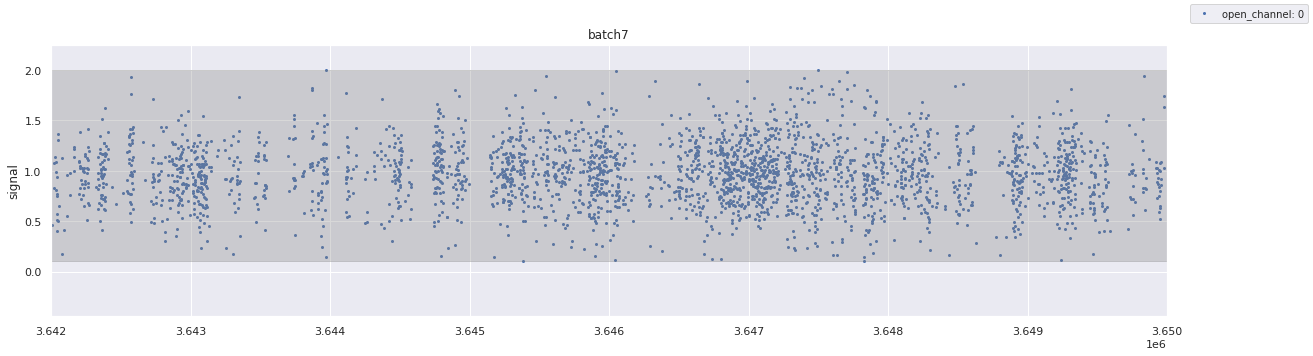

In [52]:
res = 1
x = np.arange(len(df_tr))

fig = plt.figure(figsize=(20, 5))
# for i in df_tr[df_tr['batch']==7]['open_channels'].unique():
#     idxs = (df_tr['batch'] == 7) & (df_tr['open_channels'].values==i)
#     plt.scatter(x[idxs], df_tr['signal_mod'].values[idxs], s=4, label=f'open_channel: {i}')
idxs = (df_tr['batch'] == 7) & (df_tr['open_channels'].values==3)
plt.scatter(x[idxs], df_tr['signal_mod'].values[idxs], s=4, label=f'open_channel: {i}')
    
plt.axvline(left, linestyle='--', color='black')

# batch7 signal mean (without noisy area)
idxs_noisy = (df_tr['open_channels']==3) & (left<df_tr.index) & (df_tr.index<right)
mean = df_tr[idxs_noisy]['signal'].mean()
plt.axhspan(thresh_high, thresh_low, color='gray', alpha=0.3)
# plt.axhline(mean, label='mean(open_channel=3)', color='black')
    
fig.legend(fontsize=10)
plt.xlim(3_642_000, 3_650_000)
# plt.xlim(3_642_000, 3_900_000)
plt.title('batch7')
plt.ylabel('signal')

---> OK!!

<br>

Apply the same process to all channels.

In [0]:
def create_signal_mod(train):
    left = 3641000
    right = 3829000
    thresh_dict = {
        3: [0.1, 2.0],
        2: [-1.1, 0.7],
        1: [-2.3, -0.6],
        0: [-3.8, -2],
    }
    
    train['signal_mod'] = train['signal'].values
    for ch in train[train['batch']==7]['open_channels'].unique():
        idxs_noisy = (train['open_channels']==ch) & (left<train.index) & (train.index<right)
        idxs_not_noisy = (train['open_channels']==ch) & ~idxs_noisy
        mean = train[idxs_not_noisy]['signal'].mean()

        idxs_outlier = idxs_noisy & (thresh_dict[ch][1]<train['signal'].values)
        data = np.random.normal(loc=mean, scale=0.25, size=idxs_outlier.sum()) #ガウシアンノイズを生成
        train['signal_mod'][idxs_outlier]  = data
        idxs_outlier = idxs_noisy & (train['signal'].values<thresh_dict[ch][0])
        data = np.random.normal(loc=mean, scale=0.25, size=idxs_outlier.sum()) #ガウシアンノイズを生成
        train['signal_mod'][idxs_outlier]  = data
    return train
df_tr = create_signal_mod(df_tr)

Text(0, 0.5, 'signal')

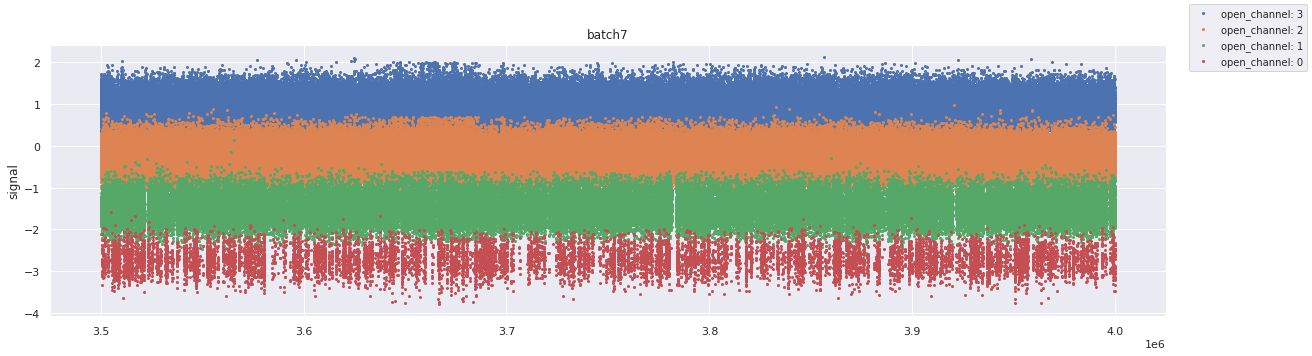

In [54]:
res = 100
x = np.arange(len(df_tr))

fig = plt.figure(figsize=(20, 5))
for i in df_tr[df_tr['batch']==7]['open_channels'].unique():
# for i in [0]:
    idxs = (df_tr['batch'] == 7) & (df_tr['open_channels'].values==i)
    plt.scatter(x[idxs], df_tr['signal_mod'].values[idxs], s=4, label=f'open_channel: {i}')
    
    
fig.legend(fontsize=10)
plt.title('batch7')
plt.ylabel('signal')

<br>

plot per open_channels

In [0]:
colors = ['blue', 'orange', 'green', 'red']

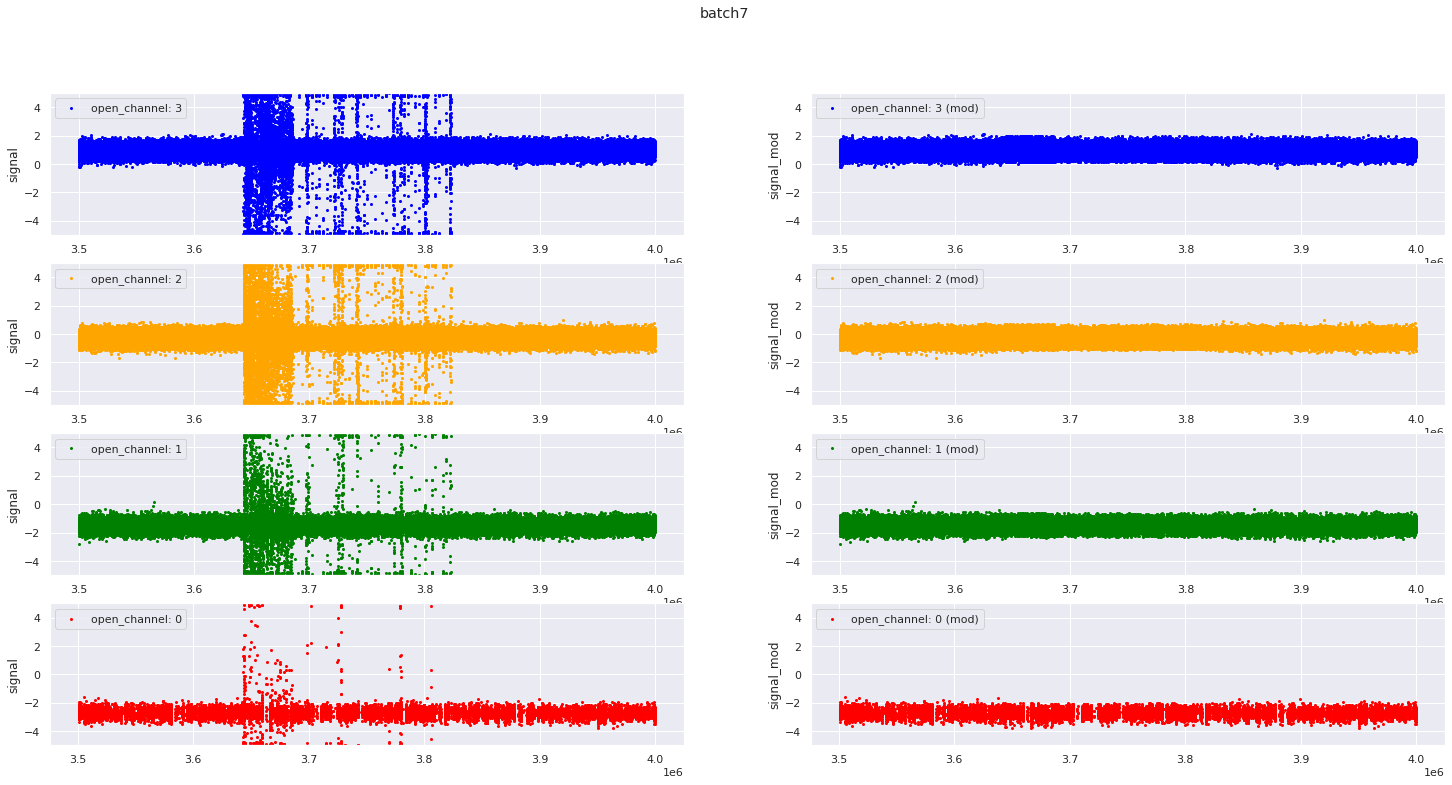

In [56]:
res = 1
fig, axs = plt.subplots(4, 2, figsize=(25, 12))
fig.suptitle('batch7')
for i_ch, ch in enumerate(df_tr[df_tr['batch']==7]['open_channels'].unique()):
    # for i in [0]:
        idxs = (df_tr['batch'] == 7) & (df_tr['open_channels'].values==ch)
        axs[i_ch, 0].scatter(x[idxs][::res], df_tr['signal'].values[idxs][::res], s=4, label=f'open_channel: {ch}', color=colors[i_ch])
        axs[i_ch, 1].scatter(x[idxs][::res], df_tr['signal_mod'].values[idxs][::res], s=4, label=f'open_channel: {ch} (mod)', color=colors[i_ch])
        axs[i_ch, 0].legend(loc='upper left')
        axs[i_ch, 1].legend(loc='upper left')
        axs[i_ch, 0].set_ylabel('signal')
        axs[i_ch, 1].set_ylabel('signal_mod')
        axs[i_ch, 0].set_ylim(df_tr['signal'][idxs][::res].min(), df_tr['signal'][idxs][::res].max())
        axs[i_ch, 1].set_ylim(df_tr['signal'][idxs][::res].min(), df_tr['signal'][idxs][::res].max())

In [0]:
df_ = pd.read_csv(PATH_TRAIN)
df_['signal'] = df_tr['signal_mod'].values

In [0]:
df_.to_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/train_clean_kalman_batch7_gause.csv', index=False)

--> goooood !!